#### IMPORTING LIBRARIES AND FUNCTIONS

In [19]:
from IPython.display import Image, display
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_community.utilities import OpenWeatherMapAPIWrapper
from langgraph.checkpoint.memory import MemorySaver
from dotenv import load_dotenv
import os

In [2]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

##### INITIALISING API KEYS

In [20]:
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
os.environ["OPENWEATHERMAP_API_KEY"] = os.getenv("OPENWEATHERMAP_API_KEY")
llm = init_chat_model(os.getenv("MODEL"))
llm2 = init_chat_model(os.getenv("MODEL"))

#### DEFINING TOOLS FOR LEVEL-1

In [21]:
@tool
def multiply(a:int,b:int)->int:
    """Multiply two numbers"""
    return a*b

@tool
def add(a:int,b:int)->int:
    """Add two numbers"""
    return a+b

@tool
def subtract(a:int,b:int)->int:
    """Subtract two numbers"""
    return a-b

@tool
def divide(a:int,b:int)->int:
    """Divide two numbers"""
    return a/b

#### DEFINING TOOLS FOR LEVEL-2

In [22]:
def search_fashion_trends(query:str)->str:
    """Fashion trends in a location"""
    search=DuckDuckGoSearchRun()
    location=llm2.invoke(f"Extract location from {query}.Give only the location")
    updated_query=f"Latest fashion trends in {location} site:vogue.com"
    return search.invoke(updated_query)

@tool
def weather(location:str)->str:
    """Get weather for a specified location"""
    weather = OpenWeatherMapAPIWrapper()
    return weather.run(location)

def error_handler(query):
    try:
        return weather.invoke(query)
    except Exception as e:
        return (f"Error: {e}")
    
error_handler("Banglore")


'Error: Unable to find the resource'

#### MEMORY FOR LEVEL-3, DEFINING A CHECKPOINTER

In [6]:
memory = MemorySaver()

#### BINDING TOOLS WITH LLM SO THAT IT IS AWARE OF THEIR EXISTENCE

In [7]:
tools=[divide,multiply,add,subtract,weather,search_fashion_trends]
llm_with_tools=llm.bind_tools(tools)

#### DEFINING CHATBOT NODE

In [8]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

#### ADDING STATE ,CHATBOT AND TOOLS NODE TO THE GRAPH

In [9]:
graph_builder = StateGraph(State)

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools",ToolNode(tools))

#### DEFINING EDGES, INTERACTION BETWEEN 2 NODES, AND COMPILING THE GRAPH BY PROVIDING CHECKPOINTER THAT WILL CHECKPOINT THE STATE AS GRPAH FIND ITS WAY THROUGH DIFFERERNT NODES(BASICALLY MEMORY RETENTION WITHOUT ANY EXTERNAL MEMORY)

#### WE ARE USINNG THE PREBUILT ROUTING LOGIC tools_condition AND HENCE NEED NOT TO DEFINE SEPARATELY

In [10]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot",tools_condition)
graph_builder.add_edge("tools","chatbot")
graph = graph_builder.compile(checkpointer=memory)

#### VISUALIZING THE AWAKENING : IMAGE OF THE GRAPH

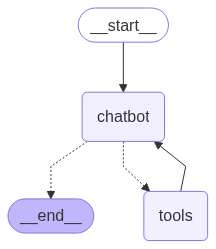

In [11]:
display(Image(graph.get_graph().draw_mermaid_png()))

#### GIVING CUSTOM RESPONSE

In [12]:
config = {"configurable": {"thread_id": "2"}}
response=graph.invoke({"messages":[HumanMessage(content="can you tell what fashion trends are trending currently in berlin.Also descrie the weather in banglore, Also tell me what is 2+3")]},config)

#### OUTPUT

In [13]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

can you tell what fashion trends are trending currently in berlin.Also descrie the weather in banglore, Also tell me what is 2+3
================================== Ai Message ==================================
Tool Calls:
  search_fashion_trends (7dac2023-c86f-4662-a887-28e20985b6b9)
 Call ID: 7dac2023-c86f-4662-a887-28e20985b6b9
  Args:
    query: berlin
  weather (4ecee8b0-0d32-4093-8f54-2ad33c6b674b)
 Call ID: 4ecee8b0-0d32-4093-8f54-2ad33c6b674b
  Args:
    location: banglore
  add (4d9a652d-96fe-410c-b6de-43af58e36616)
 Call ID: 4d9a652d-96fe-410c-b6de-43af58e36616
  Args:
    a: 2.0
    b: 3.0
================================= Tool Message =================================
Name: search_fashion_trends

Head-to-toe black and sickeningly cool looks can only mean one thing—Berlin Fashion Week is back. This season, Berliners are trying on an American classic, the Harley Davidson motorcycle jacket ... For